Best Parameters: {'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 2, 'subsample': 0.6}


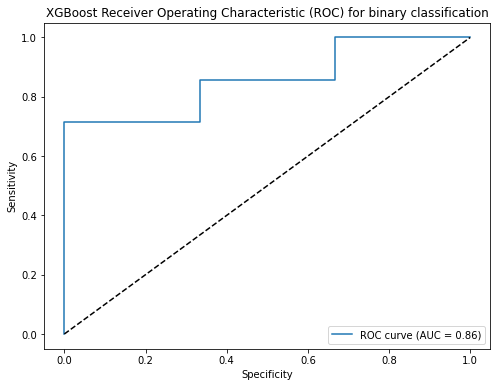

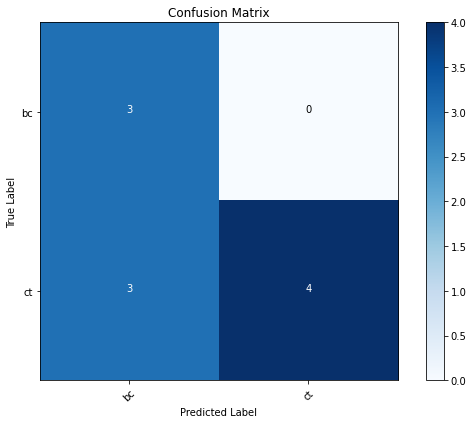

Classification Report:
              precision    recall  f1-score   support

          bc       0.50      1.00      0.67         3
          ct       1.00      0.57      0.73         7

    accuracy                           0.70        10
   macro avg       0.75      0.79      0.70        10
weighted avg       0.85      0.70      0.71        10



In [2]:
#XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, concatenate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Read the Excel spreadsheet
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_string).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

# # Flatten image features
# flattened_image_features = Flatten()(image_features)

# Preprocess numerical data (similar to image preprocessing)
# num_features = num_features.astype(np.float32)
# num_features /= num_features.max(axis=0)

# Concatenate image and numerical features
x = np.concatenate([flattened_image_features, num_features], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y_binary, test_size=0.2, random_state=42
)

# Train XGBoost model
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# params = {
#     'max_depth': 6,
#     'eta': 0.3,
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss',
#     'subsample': 0.8,
#     'colsample_bytree': 0.8
# }

# num_rounds = 100
# xgb_model = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'eval')], early_stopping_rounds=10)

# Best Parameters: {'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 3, 'subsample': 0.6}
# Best Parameters: {'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 2, 'subsample': 0.6}

param_grid = {
    # 'max_depth': [3, 6, 9],
    'max_depth': [2],
    # 'eta': [0.1, 0.2, 0.3],
    'eta': [0.2],
    # 'subsample': [0.6, 0.8, 1.0],
    'subsample': [0.6],
    # 'colsample_bytree': [0.6, 0.8, 1.0]
    'colsample_bytree': [0.8]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_log_loss')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Get predicted probabilities
y_pred_prob_XGBoost = grid_search.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for binary classification
fpr_XGBoost, tpr_XGBoost, _ = roc_curve(y_test, y_pred_prob_XGBoost)
roc_auc_XGBoost = auc(fpr_XGBoost, tpr_XGBoost)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_XGBoost, tpr_XGBoost, label=f'ROC curve (AUC = {roc_auc_XGBoost:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('XGBoost Receiver Operating Characteristic (ROC) for binary classification')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred_XGBoost = np.round(y_pred_prob_XGBoost)

cm_XGBoost = confusion_matrix(y_test, y_pred_XGBoost)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_XGBoost, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm_XGBoost.max() / 2.
for i in range(cm_XGBoost.shape[0]):
    for j in range(cm_XGBoost.shape[1]):
        plt.text(j, i, format(cm_XGBoost[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_XGBoost[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_XGBoost, target_names=label_binarizer.classes_))

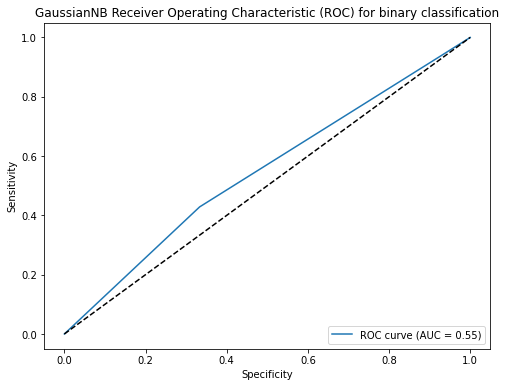

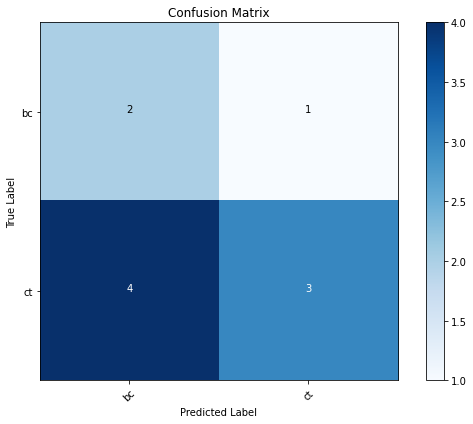

Classification Report:
              precision    recall  f1-score   support

          bc       0.33      0.67      0.44         3
          ct       0.75      0.43      0.55         7

    accuracy                           0.50        10
   macro avg       0.54      0.55      0.49        10
weighted avg       0.62      0.50      0.52        10



In [3]:
#GaussianNB model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import roc_curve, auc, classification_report

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_string).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

# # Flatten image features
# flattened_image_features = Flatten()(image_features)

# Preprocess numerical data (similar to image preprocessing)
# num_features = num_features.astype(np.float32)
# num_features /= num_features.max(axis=0)

# Concatenate image and numerical features
x = np.concatenate([flattened_image_features, num_features], axis=1)




# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
#random_state = 42

# Loop for multiple runs
# for _ in range(num_runs):
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y_binary, test_size=0.2, random_state=42)

# Convert class labels to numerical labels
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)
# num_classes = len(label_encoder.classes_)

# Create a Naive Bayes classifier
model = GaussianNB()

# Train the model
model.fit(X_train, y_train)

# Predict probabilities for each class
y_pred_prob_GaussianNB = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for binary classification
fpr_GaussianNB, tpr_GaussianNB, _ = roc_curve(y_test, y_pred_prob_GaussianNB)
roc_auc_GaussianNB = auc(fpr_GaussianNB, tpr_GaussianNB)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_GaussianNB, tpr_GaussianNB, label=f'ROC curve (AUC = {roc_auc_GaussianNB:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('GaussianNB Receiver Operating Characteristic (ROC) for binary classification')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred_GaussianNB = np.round(y_pred_prob_GaussianNB)

cm_GaussianNB = confusion_matrix(y_test, y_pred_GaussianNB)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_GaussianNB, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')



# Add text annotations
thresh = cm_GaussianNB.max() / 2.
for i in range(cm_GaussianNB.shape[0]):
    for j in range(cm_GaussianNB.shape[1]):
        plt.text(j, i, format(cm_GaussianNB[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_GaussianNB[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_GaussianNB, target_names=label_binarizer.classes_))

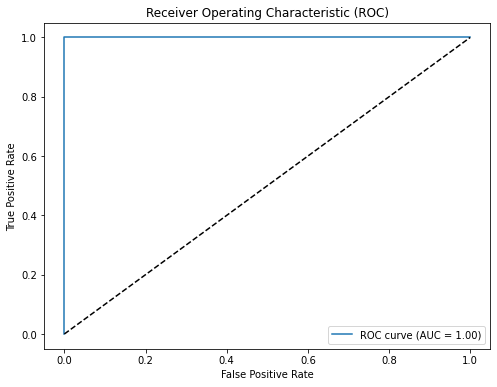

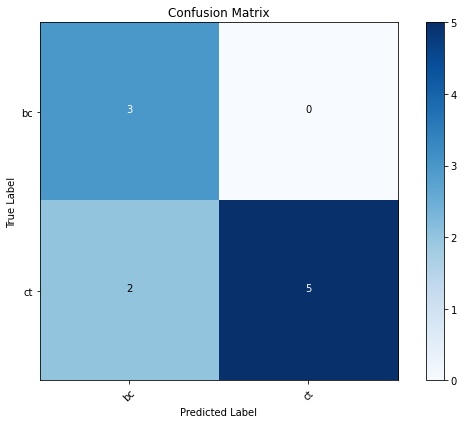

Classification Report:
              precision    recall  f1-score   support

          bc       0.60      1.00      0.75         3
          ct       1.00      0.71      0.83         7

    accuracy                           0.80        10
   macro avg       0.80      0.86      0.79        10
weighted avg       0.88      0.80      0.81        10



In [4]:
#SVM model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import roc_curve, auc, classification_report

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_string).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

# # Flatten image features
# flattened_image_features = Flatten()(image_features)

# Preprocess numerical data (similar to image preprocessing)
# num_features = num_features.astype(np.float32)
# num_features /= num_features.max(axis=0)

# Concatenate image and numerical features
x = np.concatenate([flattened_image_features, num_features], axis=1)




# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
#random_state = 42

# Loop for multiple runs
# for _ in range(num_runs):
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y_binary, test_size=0.2, random_state=42)

# Convert class labels to numerical labels
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)
# num_classes = len(label_encoder.classes_)

# Create a Naive Bayes classifier
model = SVC(probability=True, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict probabilities for each class
y_pred_prob_SVM = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for binary classification
fpr_SVM, tpr_SVM, _ = roc_curve(y_test, y_pred_prob_SVM)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_SVM, tpr_SVM, label=f'ROC curve (AUC = {roc_auc_SVM:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred_SVM = np.round(y_pred_prob_SVM)

cm_SVM = confusion_matrix(y_test, y_pred_SVM)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_SVM, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')




# Add text annotations
thresh = cm_SVM.max() / 2.
for i in range(cm_SVM.shape[0]):
    for j in range(cm_SVM.shape[1]):
        plt.text(j, i, format(cm_SVM[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_SVM[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_SVM, target_names=label_binarizer.classes_))


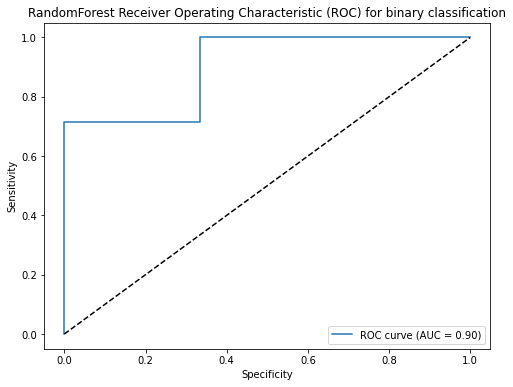

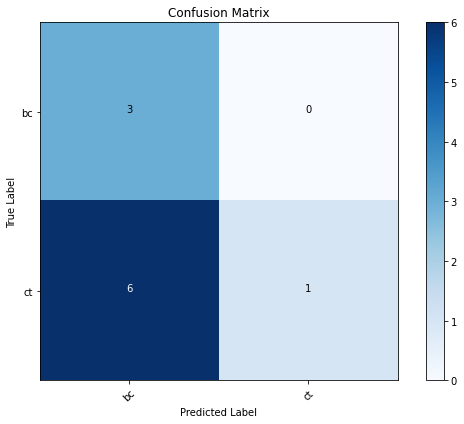

Classification Report:
              precision    recall  f1-score   support

          bc       0.33      1.00      0.50         3
          ct       1.00      0.14      0.25         7

    accuracy                           0.40        10
   macro avg       0.67      0.57      0.38        10
weighted avg       0.80      0.40      0.33        10



In [5]:
#Random Forest model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import roc_curve, auc, classification_report

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_string).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

x = np.concatenate([flattened_image_features, num_features], axis=1)




# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
#random_state = 42

# Loop for multiple runs
# for _ in range(num_runs):
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y_binary, test_size=0.2, random_state=42)

# Convert class labels to numerical labels
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)
# num_classes = len(label_encoder.classes_)


model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict probabilities for each class
y_pred_prob_RandomForest = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for binary classification
fpr_RandomForest, tpr_RandomForest, _ = roc_curve(y_test, y_pred_prob_RandomForest)
roc_auc_RandomForest = auc(fpr_RandomForest, tpr_RandomForest)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_RandomForest, tpr_RandomForest, label=f'ROC curve (AUC = {roc_auc_RandomForest:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('RandomForest Receiver Operating Characteristic (ROC) for binary classification')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred_RandomForest = np.round(y_pred_prob_RandomForest)

cm_RandomForest = confusion_matrix(y_test, y_pred_RandomForest)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_RandomForest, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


# Add text annotations
thresh = cm_RandomForest.max() / 2.
for i in range(cm_RandomForest.shape[0]):
    for j in range(cm_RandomForest.shape[1]):
        plt.text(j, i, format(cm_RandomForest[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_RandomForest[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_RandomForest, target_names=label_binarizer.classes_))

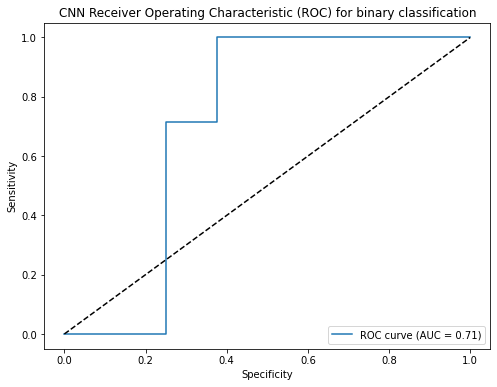

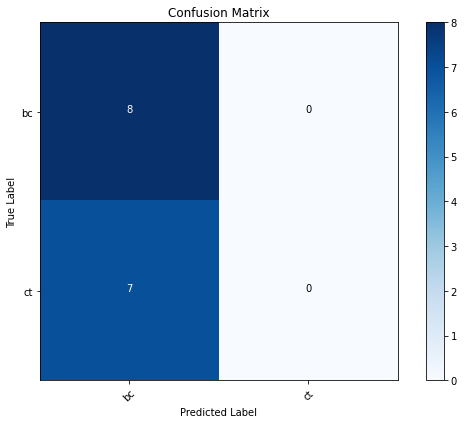

Classification Report:
              precision    recall  f1-score   support

          bc       0.53      1.00      0.70         8
          ct       0.00      0.00      0.00         7

    accuracy                           0.53        15
   macro avg       0.27      0.50      0.35        15
weighted avg       0.28      0.53      0.37        15



In [6]:
#CNN for binary classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, classification_report

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_binary = df['binary_group'].values[1:]

label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_binary).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)
X = np.concatenate([flattened_image_features, num_features], axis=1)

# Number of runs for averaging results
#num_runs = 10

# Initialize list to store AUC values for binary classification
auc_values = []

# Parameters for model training
random_state = 42

# Loop for multiple runs
#for _ in range(num_runs):
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, stratify=y_binary, random_state=random_state)


# Create a binary classification model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(25093,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid activation for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

# Predict probabilities for positive class
y_pred_prob_CNN = model.predict(X_test)

# Calculate ROC curve and AUC for binary classification
fpr_CNN, tpr_CNN, _ = roc_curve(y_test, y_pred_prob_CNN)
roc_auc_CNN = auc(fpr_CNN, tpr_CNN)
#auc_values.append((fpr, tpr))
#print(f"ROC AUC = {roc_auc:.2f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_CNN, tpr_CNN, label=f'ROC curve (AUC = {roc_auc_CNN:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('CNN Receiver Operating Characteristic (ROC) for binary classification')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred_CNN = np.round(y_pred_prob_CNN)

cm_CNN = confusion_matrix(y_test, y_pred_CNN)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_CNN, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm_CNN.max() / 2.
for i in range(cm_CNN.shape[0]):
    for j in range(cm_CNN.shape[1]):
        plt.text(j, i, format(cm_CNN[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_CNN[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_CNN, target_names=label_binarizer.classes_))


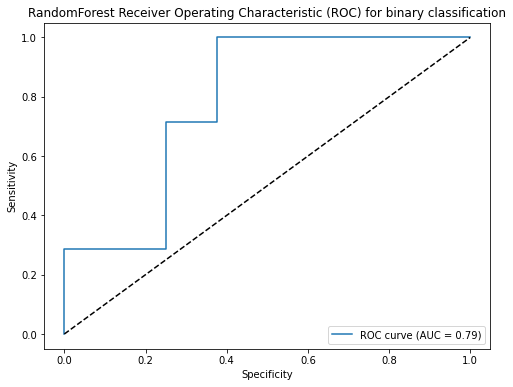

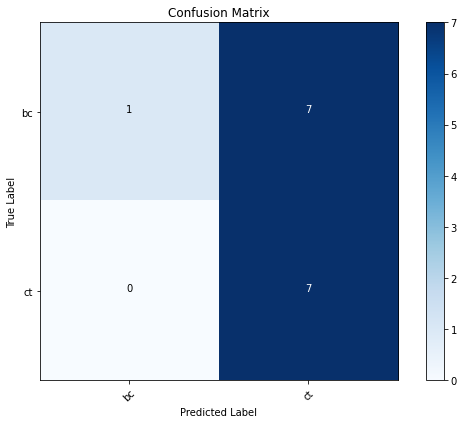

Classification Report:
              precision    recall  f1-score   support

          bc       1.00      0.12      0.22         8
          ct       0.50      1.00      0.67         7

    accuracy                           0.53        15
   macro avg       0.75      0.56      0.44        15
weighted avg       0.77      0.53      0.43        15



In [7]:
#LSTM Model for binary classification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, classification_report

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_binary = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_binary).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

# Preprocess image data
images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)
X = np.concatenate([flattened_image_features, num_features], axis=1)

# Initialize list to store AUC values for binary classification
auc_values = []

# Parameters for model training
random_state = 42

# Reshape X for LSTM input
X = X.reshape(X.shape[0], 1, X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, stratify=y_binary, random_state=random_state)

# Create an LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, 25093), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid activation for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

# Predict probabilities for positive class
y_pred_prob_LSTM = model.predict(X_test)

# Calculate ROC curve and AUC for binary classification
fpr_LSTM, tpr_LSTM, _ = roc_curve(y_test, y_pred_prob_LSTM)
roc_auc_LSTM = auc(fpr_LSTM, tpr_LSTM)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_LSTM, tpr_LSTM, label=f'ROC curve (AUC = {roc_auc_LSTM:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('RandomForest Receiver Operating Characteristic (ROC) for binary classification')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred_LSTM = np.round(y_pred_prob_LSTM)

cm_LSTM = confusion_matrix(y_test, y_pred_LSTM)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_LSTM, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


# Add text annotations
thresh = cm_LSTM.max() / 2.
for i in range(cm_LSTM.shape[0]):
    for j in range(cm_LSTM.shape[1]):
        plt.text(j, i, format(cm_LSTM[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_LSTM[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_LSTM, target_names=label_binarizer.classes_))

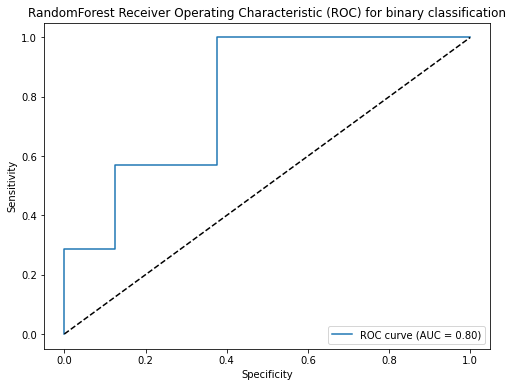

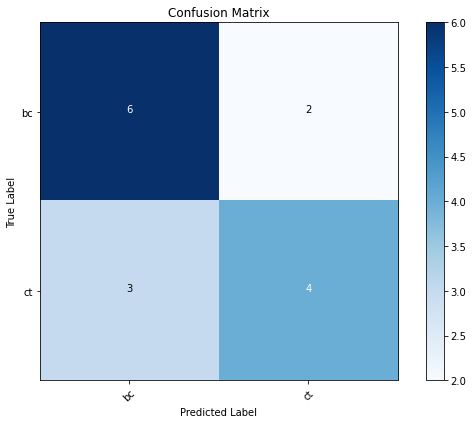

Classification Report:
              precision    recall  f1-score   support

          bc       0.67      0.75      0.71         8
          ct       0.67      0.57      0.62         7

    accuracy                           0.67        15
   macro avg       0.67      0.66      0.66        15
weighted avg       0.67      0.67      0.66        15



In [8]:
#AutoEncoder Decoder for binary classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, classification_report

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_binary = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_binary).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

X = np.concatenate([flattened_image_features, num_features], axis=1)

auc_values = []

# Parameters for model training
random_state = 42

# Reshape X for autoencoder input
X = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, stratify=y_binary, random_state=random_state)

# Create an autoencoder-decoder model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

# Encode and decode the test data

y_pred_prob_AED = model.predict(X_test)

# Calculate reconstruction error
#reconstruction_error = np.mean(np.square(X_test - encoded_X_test), axis=1)

# Calculate ROC curve and AUC for binary classification
fpr_AED, tpr_AED, _ = roc_curve(y_test, y_pred_prob_AED)
roc_auc_AED = auc(fpr_AED, tpr_AED)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_AED, tpr_AED, label=f'ROC curve (AUC = {roc_auc_AED:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('RandomForest Receiver Operating Characteristic (ROC) for binary classification')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred_AED = np.round(y_pred_prob_AED)
cm_AED = confusion_matrix(y_test, y_pred_AED)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_AED, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')




# Add text annotations
thresh = cm_AED.max() / 2.
for i in range(cm_AED.shape[0]):
    for j in range(cm_AED.shape[1]):
        plt.text(j, i, format(cm_AED[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_AED[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_AED, target_names=label_binarizer.classes_))

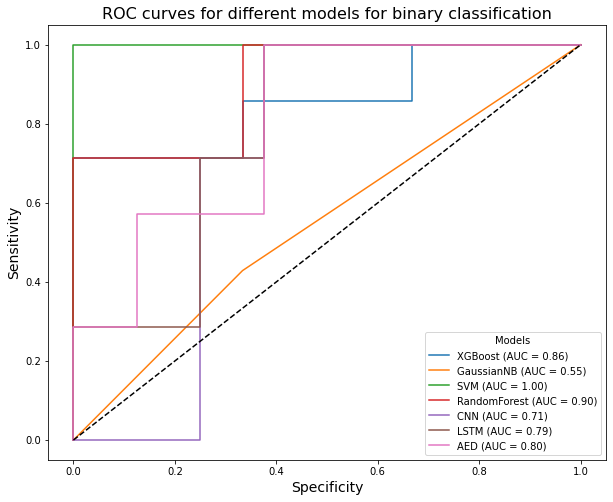

In [9]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_XGBoost, tpr_XGBoost, label=f'XGBoost (AUC = {roc_auc_XGBoost:.2f})')
plt.plot(fpr_GaussianNB, tpr_GaussianNB, label=f'GaussianNB (AUC = {roc_auc_GaussianNB:.2f})')
plt.plot(fpr_SVM, tpr_SVM, label=f'SVM (AUC = {roc_auc_SVM:.2f})')
plt.plot(fpr_RandomForest, tpr_RandomForest, label=f'RandomForest (AUC = {roc_auc_RandomForest:.2f})')
plt.plot(fpr_CNN, tpr_CNN, label=f'CNN (AUC = {roc_auc_CNN:.2f})')
plt.plot(fpr_LSTM, tpr_LSTM, label=f'LSTM (AUC = {roc_auc_LSTM:.2f})')
plt.plot(fpr_AED, tpr_AED, label=f'AED (AUC = {roc_auc_AED:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity', fontsize = 14)
plt.ylabel('Sensitivity', fontsize = 14)
plt.title('ROC curves for different models for binary classification', fontsize = 16)
plt.legend(title='Models', loc='lower right', bbox_to_anchor=(1, 0), markerscale=1)
#plt.legend(loc="lower right")
plt.show()


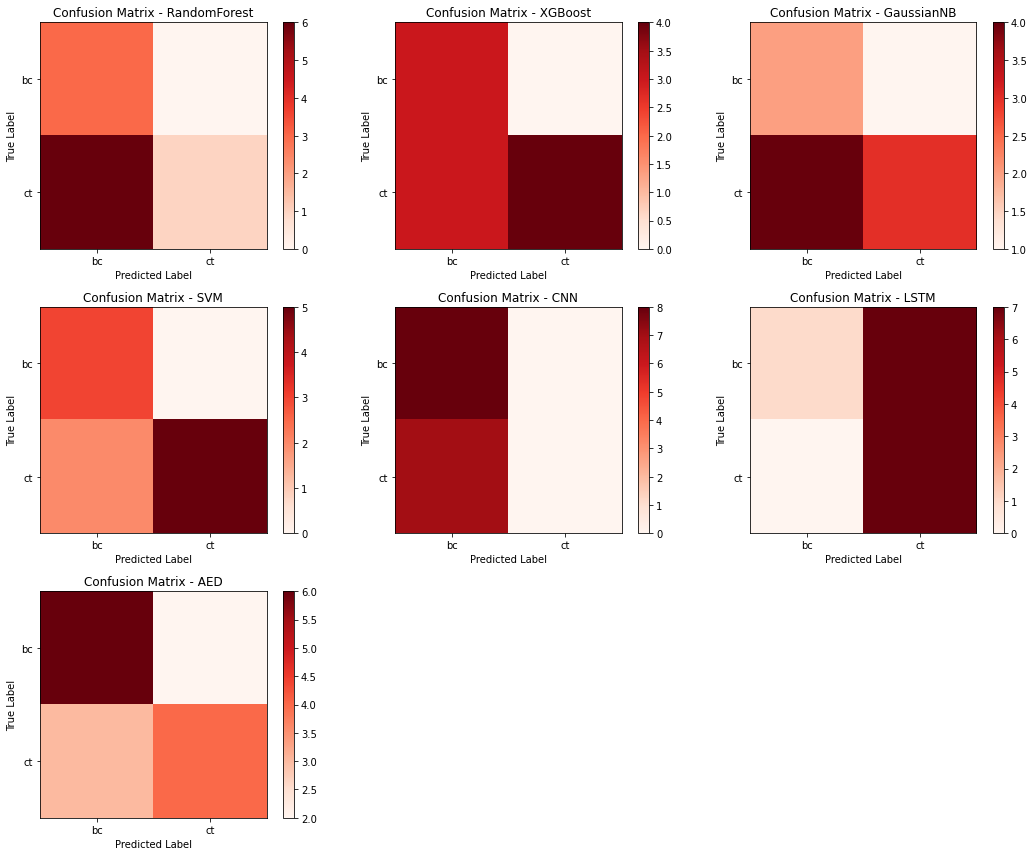

In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the confusion matrices for all models: cm_XGBoost, cm_GaussianNB, cm_SVM, cm_CNN, cm_LSTM, and cm_AED

confusion_matrices = [cm_RandomForest, cm_XGBoost, cm_GaussianNB, cm_SVM, cm_CNN, cm_LSTM, cm_AED]
model_names = ['RandomForest', 'XGBoost', 'GaussianNB', 'SVM', 'CNN', 'LSTM', 'AED']

plt.figure(figsize=(15, 12))

for i, cm in enumerate(confusion_matrices, 1):
    plt.subplot(3, 3, i)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title(f'Confusion Matrix - {model_names[i-1]}')
    plt.colorbar()
    tick_marks = np.arange(len(label_binarizer.classes_))
    plt.xticks(tick_marks, label_binarizer.classes_)
    plt.yticks(tick_marks, label_binarizer.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()
